Getting a correlation gives us weights to use for in the elo calculation

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# correlation analysis

df = pd.read_csv("2000-2024 with player stats.csv")

if df["match_outcome"].dtype == "object":
    df["match_outcome"] = df["match_outcome"].astype("category").cat.codes

num_cols = df.select_dtypes(include=["number"]).columns.tolist()
corrs = df[num_cols].corr()["match_outcome"].drop("match_outcome")
corrs_nonzero = corrs[corrs != 0].sort_values(key=lambda x: abs(x), ascending=False)


Each player starts with a 1500 Elo. Matches are paired by two rows, and opponent info is merged. Elo is updated per match using a K-factor of 20, adjusted for tournament level, score (fewer rounds = higher weight), and opponent rank. Only players with 65+ matches are kept.

In [51]:

# elo calculation

if df['match_outcome'].dtype == 'object':
    df['match_outcome'] = df['match_outcome'].astype('category').cat.codes

df = df.reset_index(drop=True)
df['match_id'] = df.index // 2

df_opponent = df[['match_id','player_id','player_name','player_rank']].copy()
df_opponent.rename(columns={
    'player_id':'player_id_opponent',
    'player_name':'opponent_name',
    'player_rank':'opponent_rank'
}, inplace=True)

df = df.merge(df_opponent, on='match_id')
df = df[df['player_id'] != df['player_id_opponent']]  # remove self-matches

all_players = pd.concat([df['player_id'], df['player_id_opponent']]).unique()
players = {player: 1500 for player in all_players}

def get_tourney_modifier(level):
    mapping = {'G':1.5, 'F':1.4, 'A':1.2, 'C':1.0, 'M':0.8, '25':0.8, 'S':0.7, 'D':1.1}
    return mapping.get(level, 1.0)

def get_score_modifier(score_str):
    if pd.isna(score_str):
        return 1.0
    rounds = score_str.count(' ') + 1
    if rounds <= 2:
        return 1.2
    elif rounds == 3:
        return 1.1
    else:
        return 1.0

def get_opponent_modifier(player_rank, opponent_rank):
    if player_rank <= 0 or opponent_rank <= 0:
        return 1.0
    return opponent_rank / player_rank

def update_elo(player_elo, opponent_elo, actual, score_mod, tourney_mod, opponent_mod, K=20):
    expected = 1 / (1 + 10 ** ((opponent_elo - player_elo)/400))
    return player_elo + K * score_mod * tourney_mod * opponent_mod * (actual - expected)

for idx, row in df.iterrows():
    player = row['player_id']
    opponent = row['player_id_opponent']
    actual = row['match_outcome']  # 1 = win, 0 = loss

    score_mod = get_score_modifier(row.get('score', None))
    tourney_mod = get_tourney_modifier(row.get('tourney_level', 'A'))
    opponent_mod = get_opponent_modifier(row.get('player_rank', 1000), row.get('opponent_rank', 1000))

    players[player] = update_elo(players[player], players[opponent], actual, score_mod, tourney_mod, opponent_mod)
    players[opponent] = update_elo(players[opponent], players[player], 1-actual, score_mod, tourney_mod, opponent_mod)

player_elos = pd.DataFrame(list(players.items()), columns=['player_id', 'elo'])
player_names = df[['player_id','player_name']].drop_duplicates()
player_elos = player_elos.merge(player_names, on='player_id', how='left')
player_elos = player_elos.sort_values('elo', ascending=False)

matches_per_player = df.groupby('player_id').size().reset_index(name='matches_played')

player_elos = player_elos.merge(matches_per_player, on='player_id', how='left')

# atleast 65 matches
player_elos = player_elos[player_elos['matches_played'] >= 65]


Showing the wins per player gives perspective to how the player kept their elo (for example: good players with alot of matches have a higher elo because they can keep winning)

(array([  1.,   0.,   0.,   0.,   1.,   4.,  11.,  30.,  62.,  96., 126.,
        109.,  97.,  88.,  75.,  47.,  40.,  20.,  17.,  12.,   7.,  10.,
          3.,   3.,   1.,   3.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 975.52907631, 1033.40397255, 1091.2788688 , 1149.15376505,
        1207.0286613 , 1264.90355755, 1322.7784538 , 1380.65335004,
        1438.52824629, 1496.40314254, 1554.27803879, 1612.15293504,
        1670.02783129, 1727.90272753, 1785.77762378, 1843.65252003,
        1901.52741628, 1959.40231253, 2017.277

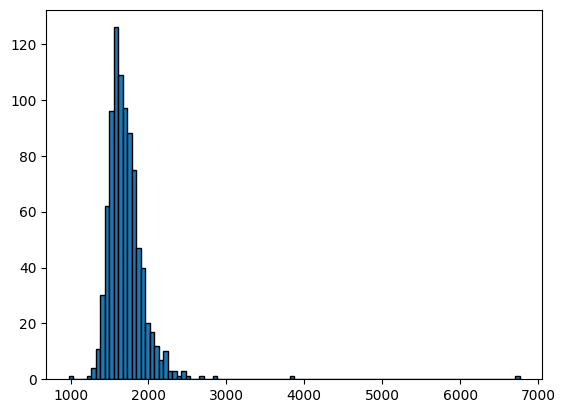

In [52]:
# count wins per player
wins_df = df[df['match_outcome'] == 1].groupby('player_id').size().reset_index(name='wins')

player_elos = player_elos.merge(wins_df, on='player_id', how='left')
player_elos['wins'] = player_elos['wins'].fillna(0).astype(int)

last_date_df = df.groupby('player_id')['tourney_date'].max().reset_index()
player_elos = player_elos.merge(last_date_df, on='player_id', how='left')

# save to CSV
player_elos.to_csv('player_elos.csv', index=False)

plt.hist(player_elos['elo'], bins=100, edgecolor='black')


Down here we we will show the elo distribution of the players with outliers removed (so everything below q1 and above q3 is gone), there were 2 players that had an elo of 1000. It starts at 1500, so for the normal distribution those outliers are gone.

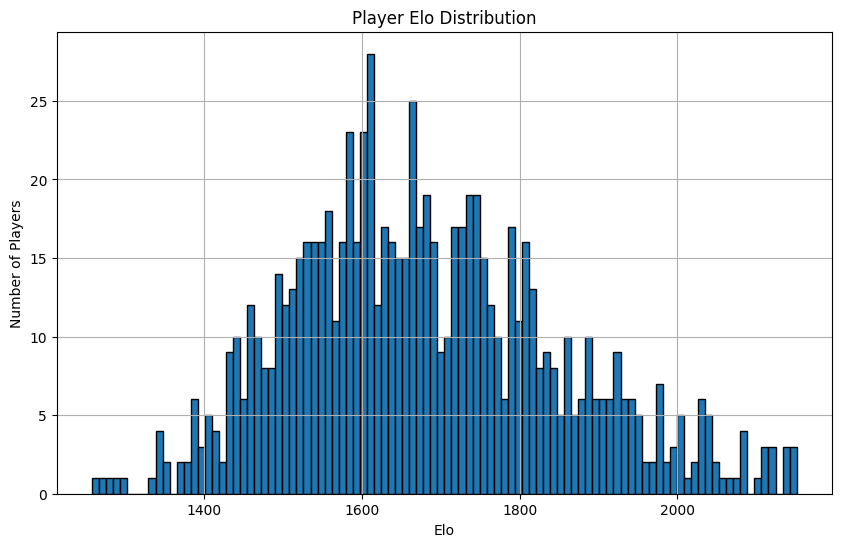

In [53]:
# calculate IQR
Q1 = player_elos['elo'].quantile(0.25)
Q3 = player_elos['elo'].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

# filter the players between whiskers
player_elos_filtered = player_elos[(player_elos['elo'] >= lower_whisker) & (player_elos['elo'] <= upper_whisker)]

# plot histogram
plt.figure(figsize=(10,6))
plt.hist(player_elos_filtered['elo'], bins=100, edgecolor='black')
plt.title("Player Elo Distribution")
plt.xlabel("Elo")
plt.ylabel("Number of Players")
plt.grid(True)
plt.show()

